In [102]:
# Import packages
import os
import tweepy as tw
import pandas as pd
import numpy as np
import re 

folder_name1 = 'data/'
folder_name = 'id_data/'
# Create data folder
if not os.path.isdir('./'+folder_name):
    os.mkdir('./'+folder_name)
    
from matplotlib import rc

# Latex rendering for plotting
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

/Users/alicepagano/anaconda3/envs/life/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


## Manipulate dataframe

In [13]:
df_2017 = pd.read_excel(folder_name1+'tag_dataset_2017.xlsx',engine='openpyxl',index_col=0,header=[0,1])
df_2018 = pd.read_excel(folder_name1+'tag_dataset_2018.xlsx',engine='openpyxl',index_col=0,header=[0,1])
df_2019 = pd.read_excel(folder_name1+'tag_dataset_2019.xlsx',engine='openpyxl',index_col=0,header=[0,1])
df_2020 = pd.read_excel(folder_name1+'tag_dataset_2020.xlsx',engine='openpyxl',index_col=0,header=[0,1])

data = pd.concat([df_2020],ignore_index=True)
#data = pd.concat([df_2020],ignore_index=True)

# Filter only for novax people
data = data[data[('user','tag')]==1]

# Fill lat and lon province for user with only the region information by associating capitals
df_reg = pd.read_excel('../useful_datasets/italian_regions_new.xlsx',engine='openpyxl')

regions = df_reg['region']
province = df_reg['capitals']
lat = df_reg['lat']
lon = df_reg['lon']




# TO FIX BOLZANO AND TRENTO PROBLEM!!!!!!!!!!!!!
cit = ['bolzano','trento']
for i in range(len(cit)):
    mask = data[("user","province")].notnull() & data[("user","province")].str.contains(fr'\b{cit[i]}\b', regex=True, case=False)
    data.loc[mask,("user","region")] = cit[i]

# TO CHANGE IF WE WANT TO DO PROVINCE ANALYSIS!!!!!!!!!!!!!!!!!!
for i in range(len(regions)):
    # If city is null, associate latitude and longitude of the capital of the region
    mask = data[("user","region")].str.contains(fr'\b{regions[i]}\b', regex=True, case=False)
    data.loc[mask,("user","province")] = province[i] 
    data.loc[mask,("user","lat_province")] = lat[i] 
    data.loc[mask,("user","lon_province")] = lon[i]


    
#for i in range(len(regions)):
#    # If city is null, associate latitude and longitude of the capital of the region
#    mask = data[("user","city")].isnull() & data[("user","region")].str.contains(fr'\b{regions[i]}\b', regex=True, case=False)
#    data.loc[mask,("user","province")] = province[i] 
#    data.loc[mask,("user","lat_province")] = lat[i] 
#    data.loc[mask,("user","lon_province")] = lon[i]
    

# Add column total population per province
df_pop = pd.read_excel('../useful_datasets/abitanti_per_regione.xlsx',engine='openpyxl')

region = df_pop['region']
tweet_activity = df_pop['tweet_percentage']

for i in range(len(region)):
    mask = data[("user","region")].str.contains(fr'\b{region[i]}\b', regex=True, case=False)
    data.loc[mask,("user","tweet_activity")] = tweet_activity[i] 

data["tweet","if_retweet"] = 0

for i in range(len(region)):
    mask = data[("tweet","text")].str.contains('RT @', regex=True, case=True)
    data.loc[mask,("tweet","if_retweet")] = 1
    
# Add column total population per province
#df_pop = pd.read_excel('../useful_datasets/pop_province.xlsx',engine='openpyxl')

#province = df_pop['Province']
#pop_total = df_pop['Total']

#for i in range(len(province)):
#    mask = data[("user","province")].str.contains(fr'\b{province[i]}\b', regex=True, case=False)
#    data.loc[mask,("user","total_population")] = pop_total[i] 
data.shape

(228, 23)

In [14]:
# Associate a weight to each tweet of a user
#data[('user','user_weight')] = (1 + data[('tweet','favorites_count')] + 5*data[('tweet','retweet_count')])/data[('user','total_population')]
mask = data[("tweet","if_retweet")]==0
data.loc[mask,("user","user_weight_p")] = (1 + data[('tweet','favorites_count')] + 5*data[('tweet','retweet_count')])/data[('user','tweet_activity')]
  
mask = data[("tweet","if_retweet")]==1 
data.loc[mask,("user","user_weight_p")] = (1 + data[('tweet','favorites_count')])/data[('user','tweet_activity')]
 
#data[('user','user_weight_p')] = (1 + data[('tweet','favorites_count')] + 5*data[('tweet','retweet_count')])/data[('user','tweet_activity')]

# Associate to each unique ID the sum of the corresponding weights
data[('user','user_weight')] = data[('user','id')].map( data['user'].groupby(('id'))['user_weight_p'].agg('sum') )

data_unique_user = data.drop_duplicates(subset=[('user','id')])

# Associate to each unique province the sum of the corresponding weights of all the utents
#data[('user','province_weight')] = data[('user','province')].map( data['user'].groupby(('province'))['user_weight'].agg('sum') )
data_unique_user[('user','region_weight')] = data_unique_user[('user','region')].map( data_unique_user['user'].groupby(('region'))['user_weight'].agg('sum') )

# Associate to each unique province the sum of the corresponding weights of all the utents
####data[('user','region_weight')] = data[('user','region')].map( data['user'].groupby(('region'))['user_weight'].agg('sum') )

data_unique_user

/Users/alicepagano/anaconda3/envs/life/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


user                       \
         screen_name                   id   
0      calzelunghe17           4893362397   
1          menelik40            519786647   
2          xenonian1           3327831430   
3       CLiVaToscana   923171889891209216   
4       AndreaLisi15  1172571984967941888   
..               ...                  ...   
268          colmarn            626803701   
270          EURybor   799007315034800128   
274   LUDOVICOTODINI            954758785   
275        tiecolino            433717645   
276  silviasilvierba           4133201997   

                                                                           \
                                           description           location   
0    Leggere è una forma di felicità, non si può ob...     belluno veneto   
1                                                 None   salerno campania   
2    Operatore cinema/tv,fotografo,cinefilo. Amo i ...         roma italy   
3    Comitato per la Libertà di scelta Vaccinale - ...     toscana italia   
4                                                 None   milano lombardia   
..                                                 ...                ...   
268  Non prævalebunt. Alumnus PoliMi et МИРЭА. Bot ...   milano lombardia   
270  Non mi interessa avere ragione.\nTutta la vita...      fermo italia    
274  Self Employed - Sempre a Destra - 2008-2013 Co...               roma   
275  La Verità rende gli uomini liberi. Non ho un p...       Napoli-Rieti   
276               moglie,madre e libera professionista  Milano, Lombardia   

                                                                        tweet  \
    followers_count favourites_count          created_at                   id   
0               441            29476 2016-02-09 23:18:19  1223301908783301120   
1              1044             7659 2012-03-09 20:15:49  1223229885235200000   
2              1406           178761 2015-06-15 19:29:51  1223221289411890944   
3               608              512 2017-10-25 12:58:25  1223175880605827072   
4               224             6138 2019-09-13 18:05:31  1220828033847889920   
..              ...              ...                 ...                  ...   
268             779            41346 2012-07-04 19:35:14  1303606251889349120   
270             167            29119 2016-11-16 21:52:43  1303575879617064960   
274            3269            84920 2012-11-18 03:18:31  1277191574020067072   
275            3198            83886 2011-12-10 22:56:34  1303601056627204096   
276            1268            31510 2015-11-07 09:43:04  1277700387697570048   

                                \
                    created_at   
0   2020-01-31 17:47:57.000001   
1   2020-01-31 13:01:45.000000   
2   2020-01-31 12:27:36.000000   
3   2020-01-31 09:27:10.000000   
4   2020-01-24 21:57:39.000000   
..                         ...   
268 2020-09-09 08:08:44.000000   
270 2020-09-09 06:08:02.999999   
274 2020-06-28 10:46:14.000000   
275 2020-09-09 07:48:06.000000   
276 2020-06-29 20:28:05.000000   

                                                        ...     user           \
                                                  text  ...     city province   
0    RT @CLiVaToscana: Ma come? Non avevano detto c...  ...  belluno  venezia   
1    RT @CLiVaToscana: Ma come? Non avevano detto c...  ...  salerno   napoli   
2    RT @CLiVaToscana: Ma come? Non avevano detto c...  ...     roma     roma   
3    Ma come? Non avevano detto che con la 119 era ...  ...      NaN  firenze   
4    RT @mirddyn_rm: Giusto, ha ragione. Oggigiorno...  ...   milano   milano   
..                                                 ...  ...      ...      ...   
268  RT @angy_cocco: Quanti, tantissimi così...\n#d...  ...   milano   milano   
270  RT @angy_cocco: Quanti, tantissimi così...\n#d...  ...    fermo   ancona   
274  RT @bettabettanesi: @LUDOVICOTODINI   #Lorenzi...  ...     roma     roma   
275  RT @angy_cocco: Quanti, tantissimi 

In [15]:
data_unique_id = data_unique_user.drop_duplicates(subset=[('user','id')])

# Convert to a file excel
data_unique_id.to_excel(folder_name+'tweet_user_dataset_20.xlsx') 
#data_unique_region.to_excel(folder_name+'tweet_region_dataset_20.xlsx') 
print('Dimension of the entire dataset (after removing duplicates id):',data_unique_id.shape) 

Dimension of the entire dataset (after removing duplicates id): (135, 26)


In [16]:
# Simple check
#data[data[('user','province')]=="reggio nell'emilia"].drop_duplicates(subset=[('user','id')])

In [17]:
#data_unique_province = data.drop_duplicates(subset=[('user','province')])
# Convert to a file excel
#data_unique_province.to_excel(folder_name+'tweet_province_dataset_17-18-19.xlsx') 
#print('Dimension of the entire dataset (after removing duplicates provinces):',data_unique_province.shape) 

## Overlap

In [18]:
df_2017 = pd.read_excel(folder_name+'tweet_user_dataset_17.xlsx',engine='openpyxl',index_col=0,header=[0,1])
df_2018 = pd.read_excel(folder_name+'tweet_user_dataset_18.xlsx',engine='openpyxl',index_col=0,header=[0,1])
df_2019 = pd.read_excel(folder_name+'tweet_user_dataset_19.xlsx',engine='openpyxl',index_col=0,header=[0,1])
df_2020 = pd.read_excel(folder_name+'tweet_user_dataset_20.xlsx',engine='openpyxl',index_col=0,header=[0,1])

In [29]:
import gzip
import io
import pprint
import upsetplot
import pandas as pd
from collections import defaultdict
from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt
from urllib.request import Request, urlopen

In [88]:
years = defaultdict(list)

df_all = [[df_2017,'17'],[df_2018,'18'],[df_2019,'19'],[df_2020,'20']]

for df in df_all:
    for index, row in df[0].iterrows():
        years[df[1]].append(row[('user','id')])
        #print(row[('user','id')])

In [89]:
pp = pprint.PrettyPrinter(indent=4, depth=1)
print("Data structure: ")
pp.pprint(years)

Data structure: 
defaultdict(<class 'list'>,
            {   '17': [...],
                '18': [...],
                '19': [...],
                '20': [...]})


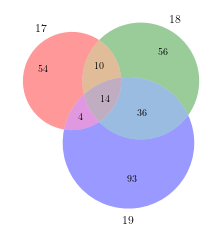

In [123]:
venn3([set(years['17']), set(years['18']), set(years['19']) ], 
      set_labels = ('17', '18','19'))

In [98]:
years_set = dict()
for k, v in years.items():
    years_set[k] = set(v)

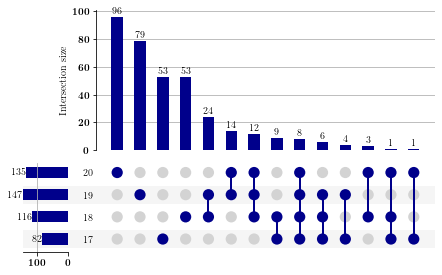

In [126]:
def plot_upset(years_set, categories, filename):
    upset_data_sub = upsetplot.from_contents({k: v for k, v in years_set.items() if k.startswith(categories)})
    upsetplot.plot(upset_data_sub,sort_categories_by=None,sort_by='cardinality',
                  facecolor='darkblue',show_counts=True,orientation='horizontal')
    plt.savefig(filename,format='pdf',bbox_inches = "tight")
    return

plot_upset(years_set, ('17','18','19','20'), "./overlap.pdf")
